In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils import data
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np

In [2]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [40]:
EPOCHS     = 5
BATCH_SIZE = 64

In [4]:
transform=transforms.Compose([
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor()
                   ])

RandomHorizontalFlip을 통해 이미지를 무작위로 수평 뒤집기를 합니다.

In [56]:
trainset = datasets.MNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transform
)
testset = datasets.MNIST(
    root      = './.data/', 
    train     = False,
    download  = True,
    transform = transform
)

In [8]:
train_loader = data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE, shuffle=True
)
test_loader = data.DataLoader(
    dataset     = testset,
    batch_size  = BATCH_SIZE, shuffle=True
)

In [9]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

In [10]:
images[0].shape

torch.Size([1, 28, 28])

In [11]:
print(labels)

tensor([3, 6, 6, 2, 3, 3, 2, 7, 9, 7, 3, 0, 8, 2, 1, 6, 1, 2, 3, 0, 1, 8, 5, 1,
        8, 0, 2, 8, 5, 6, 1, 5, 2, 3, 5, 7, 0, 5, 9, 3, 6, 5, 9, 6, 9, 5, 5, 1,
        5, 0, 2, 6, 9, 3, 0, 4, 7, 1, 0, 5, 5, 1, 2, 2])


In [12]:
CLASSES = {
    0: 'zero',
    1: 'one',
    2: 'two',
    3: 'three',
    4: 'four',
    5: 'five',
    6: 'six',
    7: 'seven',
    8: 'eight',
    9: 'nine'
}


for label in labels:
    index = label.item()
    print(CLASSES[index])

three
six
six
two
three
three
two
seven
nine
seven
three
zero
eight
two
one
six
one
two
three
zero
one
eight
five
one
eight
zero
two
eight
five
six
one
five
two
three
five
seven
zero
five
nine
three
six
five
nine
six
nine
five
five
one
five
zero
two
six
nine
three
zero
four
seven
one
zero
five
five
one
two
two


(28, 28)


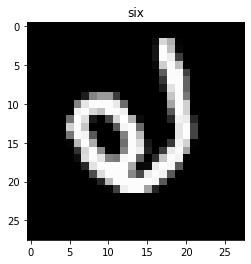

In [13]:
idx = 1

item_img = images[idx]
item_npimg = item_img.squeeze().numpy()
plt.title(CLASSES[labels[idx].item()])
print(item_npimg.shape)
plt.imshow(item_npimg, cmap='gray')
plt.show()

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 784)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))        
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

dropout_p파라미터를 클래스에 추가합니다. 0.2로 설정했다는 것은, 학습 시 20%의 뉴런을 사용하지 않겠다는 뜻과 같습니다. F.dropout()함수만 추가해주면 dropout이 구현됩니다. F.dropout()함수는 가중치가 없으므로 바로 사용할 수 있고 취향에 따라 nn.Dropout클래스를 사용하여도 무방합니다. nn.Dropout은 내부적으로 F.dropout()함수를 씁니다. 클래스를 쓰느냐 함수를 쓰느냐의 차이입니다.
dropout은 학습 모드에서만 사용하고 평가 모드에서는 모든 뉴런을 사용해야 하기 때문에 모델이 model.train()과 model.eval()함수를 호출하여 모드를 바꿀 때 마다 모델 내부의 self.training 변수 값이 True나 False로 바뀝니다.

In [20]:
class Net(nn.Module):
    def __init__(self, dropout_p=0.2):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        # 드롭아웃 확률
        self.dropout_p = dropout_p

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        # 드롭아웃 추가
        x = F.dropout(x, training=self.training,
                      p=self.dropout_p)
        x = F.relu(self.fc2(x))
        # 드롭아웃 추가
        x = F.dropout(x, training=self.training,
                      p=self.dropout_p)
        x = self.fc3(x)
        return x

### Convolution 모델을 같이 작성해봅시다.

이번 CNN모델은 커널 크기가 5이고 컨벌루션 계층은 2개입니다. Conv2d(입력 채널 수, 출력 채널 수)입니다. MNIST는 흑백이미지이므로 채널(색상)이 1개 뿐입니다. 따라서 입력 채널이 1, 그리고 10개의 특징맵을 생성하고, 두번째 Conv2d에서 20개의 특징 맵을 만듭니다. 커널(필터)크기는 kernel_size로 지정합니다. 숫자 하나만 지정하면 정사각형으로 간주하고, (3,5)와 같은 배열을 입력하여 3x5크기의 직사각형으로도 만들 수 있습니다.
이번에는 nn.Dropout2d()모듈을 이용하여 드롭아웃 인스턴스를 만듭니다.

In [36]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(self.conv2_drop(F.relu(self.conv2(x))), 2)
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

이제 신경망을 거칩니다. 첫번 째 입력이 320인 이유는, 28x28정사각형 이미지에 5x5로 kernel size가 지정되어 있으면 28-4 = 24가 됩니다. 이를 max_pool2d를 2로 지정했으니 24/2 = 12입니다. 이제 12x12에서 또 5x5이므로 12-4=8에 max_pool2d 8/2=4. 즉 최종적으로 4x4에 채널 수 20개 즉, 16x20 = 360의 이미지가 입력으로 들어갑니다.

In [50]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(20)
        self.conv2_drop = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(self.conv2_drop(F.relu(self.bn2(self.conv2(x)))), 2)
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [51]:
model     = Net().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
       BatchNorm2d-2           [-1, 10, 24, 24]              20
            Conv2d-3             [-1, 20, 8, 8]           5,020
       BatchNorm2d-4             [-1, 20, 8, 8]              40
         Dropout2d-5             [-1, 20, 8, 8]               0
            Linear-6                   [-1, 50]          16,050
            Linear-7                   [-1, 10]             510
Total params: 21,900
Trainable params: 21,900
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.08
Estimated Total Size (MB): 0.20
----------------------------------------------------------------


In [52]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [53]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

output.max()함수는 2개의 값을 출력합니다. 가장 큰 값과 그 값에 대한 index입니다. 우리는 가장 큰 값보다는 인덱스에 더 관심이 있습니다.
일치하는지 여부를 eq()를 통해 판단. 값이 일치하면 1, 불일치하면 0을 출력합니다. .sum()함수로 배열 내의 값을 모두 더하면 현재 배치에서 모델이 정답을 맞춘 개수를 구할 수 있습니다. view_as 함수는 target 텐서를 (pred)의 모양대로 다시 정렬합니다.
모델의 전체 데이터셋에 대한 오차와 맞힌 개수의 합이 구해졌습니다. 이 값들을 테스트셋의 데이터수로 나눠 평균을 구합니다. 총 정답 평균에는 100을 곱하여 정확도를 구했습니다.

In [54]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300168
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.014047
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.734926
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.675930
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.491273
[1] Test Loss: 0.2969, Accuracy: 91.04%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.621903
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.712667
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.393500
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.653050
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.283200
[2] Test Loss: 0.1928, Accuracy: 94.54%
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.420823
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.231030
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.542391
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.249317
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.446789
[3] Test Loss: 0.1387, Accuracy: 95.82%
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.265779
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.432142
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.233983


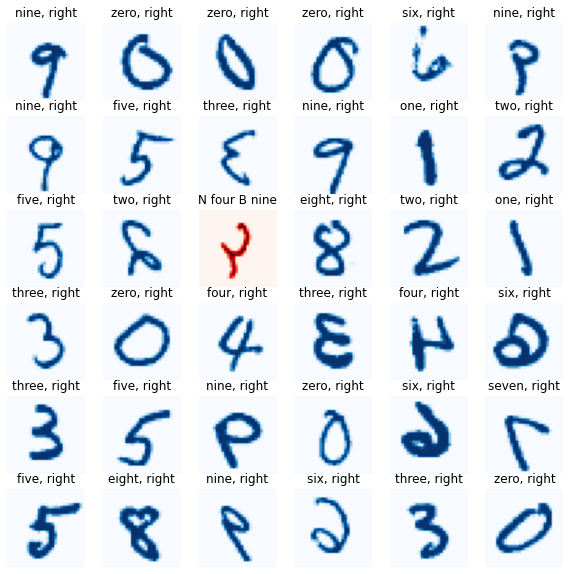

In [55]:
columns = 6
rows = 6
fig = plt.figure(figsize=(10,10))
 
model.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(testset))
    input_img = testset[data_idx][0].unsqueeze(dim=0).to(DEVICE) 
 
    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = CLASSES[argmax.item()]
    label = CLASSES[testset[data_idx][1]]
    
    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + ', right')
        cmap = 'Blues'
    else:
        plt.title('N ' + pred + ' B ' +  label)
        cmap = 'Reds'
    plot_img = testset[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')
    
plt.show() 

##  CNN을 이용해 Fashion MNIST 분류문제를 풀어봅시다

In [20]:
trainset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transform
)
testset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = False,
    download  = True,
    transform = transform
)

In [21]:
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}


for label in labels:
    index = label.item()
    print(CLASSES[index])

T-shirt/top
Dress
Sneaker
Sneaker
Dress
Coat
Dress
Shirt
Sandal
T-shirt/top
Ankle boot
Trouser
Sneaker
Coat
Dress
Sneaker
Dress
Pullover
Sneaker
Pullover
Trouser
Shirt
Sandal
Sneaker
Sneaker
Shirt
Ankle boot
Dress
Sneaker
Pullover
Ankle boot
Bag
Shirt
T-shirt/top
Ankle boot
Coat
Coat
Pullover
Coat
Sneaker
Coat
Bag
T-shirt/top
Shirt
Pullover
Trouser
Dress
Shirt
Trouser
Trouser
Dress
Ankle boot
Sandal
Shirt
Trouser
Sandal
Sneaker
Sandal
Trouser
Shirt
Dress
Trouser
Trouser
Sandal


https://github.com/zalandoresearch/fashion-mnist